# Prédiction de valeurs manquantes : application à des mesures de capteur

Yewan Wang, Guillaume Simon @ Miratlas, Inès Hafassa Maïza @ DataCraft
Juillet 2023

## Thème
Prétraitement des données de séries temporelles pour la complétion des turbulences atmosphériques liées aux conditions météorologiques.

## Contexte
La société "Miratlas" déploie un réseau instrumental mondiale pour surveiller les conditions météorologiques, en particulier les turbulences, afin de caractériser les conditions atmosphériques pour la communication optique en espace libre. Les variables de turbulence sont mesurées en observant les objets célestes brillants dans le ciel, tels que le soleil pendant la journée et Polaris pendant la nuit. Cependant, l'instrument ne peut pas effectuer de mesures efficaces si le soleil ou l'étoile est invisible, par exemple lorsqu'il y a des nuages ou lorsque les objets célestes sont en dessous de l'altitude d'observation. Par conséquent, nous avons de nombreuses valeurs manquantes pour les variables de turbulences. En revanche, la station météorologique obtient normalement des mesures continues sans interruption. Dans cet atelier, nous souhaitons analyser les relations internes et potentielles entre les variables de turbulence et les données météorologiques, afin de déterminer si nous pouvons obtenir des prédictions à court terme des turbulences en utilisant les variables météorologiques pour compléter les measures manquantes de la turbulence.

## Plan
1. Introduction : Présentation de la problématique et des enjeux.
2. Visualization et prétraitement des données : Observation les évolutions et les valeurs manquantes des données.
3. Exploration des données : Analyse statistique des jeux de données, en terme de la corrélation, la saisonalité, les valeurs aberrantes pour explorer les relations potentielles entre les variables météorologiques et les turbulences.
4. Méthodes pre-selectionnées: <br>
    4.1. Modélisation prédictive : Construction d'un modèle prédictif en utilisant des techniques d'apprentissage automatique pour estimer les turbulences à court terme en fonction des données météorologiques.
5. Évaluation des performances : Évaluation du modèle prédictif et discussion des résultats obtenus.
6. Conclusion : Discusion les résultats obtenus ensemble.


## 1. Introduction 
### Turbulence atmosphérique
La turbulence atmosphérique fait référence à l’instabilité des mouvements de l’air. Comme un faisceau laser se propage dans l’atmosphère, son front d’onde subit des distorsions dues à des inhomogénéités dans l’indice de réfraction de l’air, qui sont causées par des variations de température et de pression. Ces effets sur un système optique peuvent être quantifiés par des paramètres de vision atmosphérique tels que la longueur de cohérence atmosphérique (paramètre Fried, r0) et l’angle isoplanatique.

Source:
- Apprends la science qui sous-tend les quatre principales causes de turbulence: https://parlonssciences.ca/ressources-pedagogiques/les-stim-expliquees/quest-ce-que-la-turbulence-atmospherique#:~:text=La%20turbulence%20en%20air%20clair%20se%20produit%20lorsque%20deux%20masses,de%20l'atmosph%C3%A8re%20appel%C3%A9e%20tropopause.

### Description du jeu de données 
1. time: sampling time  datetime64
2. d_ext_temp: external temperature, float64
3. d_humid: relative humidity, float64
4. d_rain_rate：rain rate, float64       
5. d_wind: wind speed, float64       
6. d_wind_dir: wind direction, 0° North, 180° south, float64       
7. __day_r0__: Fried parameter r0 day, float64       
8. __day_see__: Day Seeing, float64       
9. __day_see_stddev__, float64       
10. down_ir: downwelling irrandance, radiation infrared, float64       
11. humid: internal humidity, float64       
12. irrad: irradance, float64       
13. __isoplan__: Night Seeing isoplanetisme angle, Related to scintillation, float64       
14. __night_r0__: Fried parameter r0 night, float64       
15. __night_see__: Night Seeing, float64       
16. press: pression, float64       
17. pyr_temp: Pyrgeomete temperature, at 52° elevation, float64       
18. __scint__: Scintillation night, float64, 0-255       
19. sky_temp: sky temperature, float64       
20. status: four catogeries based on status of DIMM: Day time, Cloudy, Night time, Polaris locked $^*$ , string        
21. transp: Transparency night, float64, 0-255       
22. wat_col_hei: Total Water Column, water vapor, float64    

$^*$ : concerne l'étoile Polaris 

__en gras__ : les variables caractérisant la turbulence

## 2. Visualisation et prétraitement


Observation les évolutions et les valeurs manquantes des données, pretraitement des données brutes.

### 2.1 Importation des données

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

cols_names = ['time', 'status', 'd_ext_temp', 'd_humid', 'd_rain_rate', 'd_wind', 'd_wind_dir', 'day_r0', 'day_see', 
            'day_see_stddev', 'down_ir', 'humid', 'irrad', 'isoplan', 'night_r0', 'night_see', 'press',
            'pyr_temp', 'scint', 'sky_temp', 'transp', 'wat_col_hei']
column_types = ['string', 'string', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32',
                'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32']


dtype = dict(zip(cols_names, column_types))

df = pd.read_csv('data/tenerife_2020.csv', usecols=cols_names, dtype=dtype)
df.replace(0, np.nan, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['time'] = pd.to_datetime(df['time'], unit='ns')

df[df['time'].dt.month == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33129 entries, 0 to 33128
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            33129 non-null  datetime64[ns]
 1   d_ext_temp      33129 non-null  float32       
 2   d_humid         29957 non-null  float32       
 3   d_rain_rate     238 non-null    float32       
 4   d_wind          31911 non-null  float32       
 5   d_wind_dir      33129 non-null  float32       
 6   day_r0          7007 non-null   float32       
 7   day_see         7007 non-null   float32       
 8   day_see_stddev  6915 non-null   float32       
 9   down_ir         33129 non-null  float32       
 10  humid           33129 non-null  float32       
 11  irrad           33129 non-null  float32       
 12  isoplan         0 non-null      float32       
 13  night_r0        0 non-null      float32       
 14  night_see       0 non-null      float32       
 15  pr

### 2.2 Valeurs manquantes

Dataframe des variables associées leurs taux de valeurs manquantes
                     0
time              0.00
d_ext_temp        0.00
d_humid           3.88
d_rain_rate      99.03
d_wind           12.97
d_wind_dir        0.00
day_r0           73.92
day_see          73.92
day_see_stddev   74.20
down_ir           0.00
humid             0.03
irrad             0.01
isoplan         100.00
night_r0         75.88
night_see        75.88
press             0.00
pyr_temp          0.00
scint            73.14
sky_temp          0.00
status           17.37
transp           66.78
wat_col_hei       0.00


<AxesSubplot:>

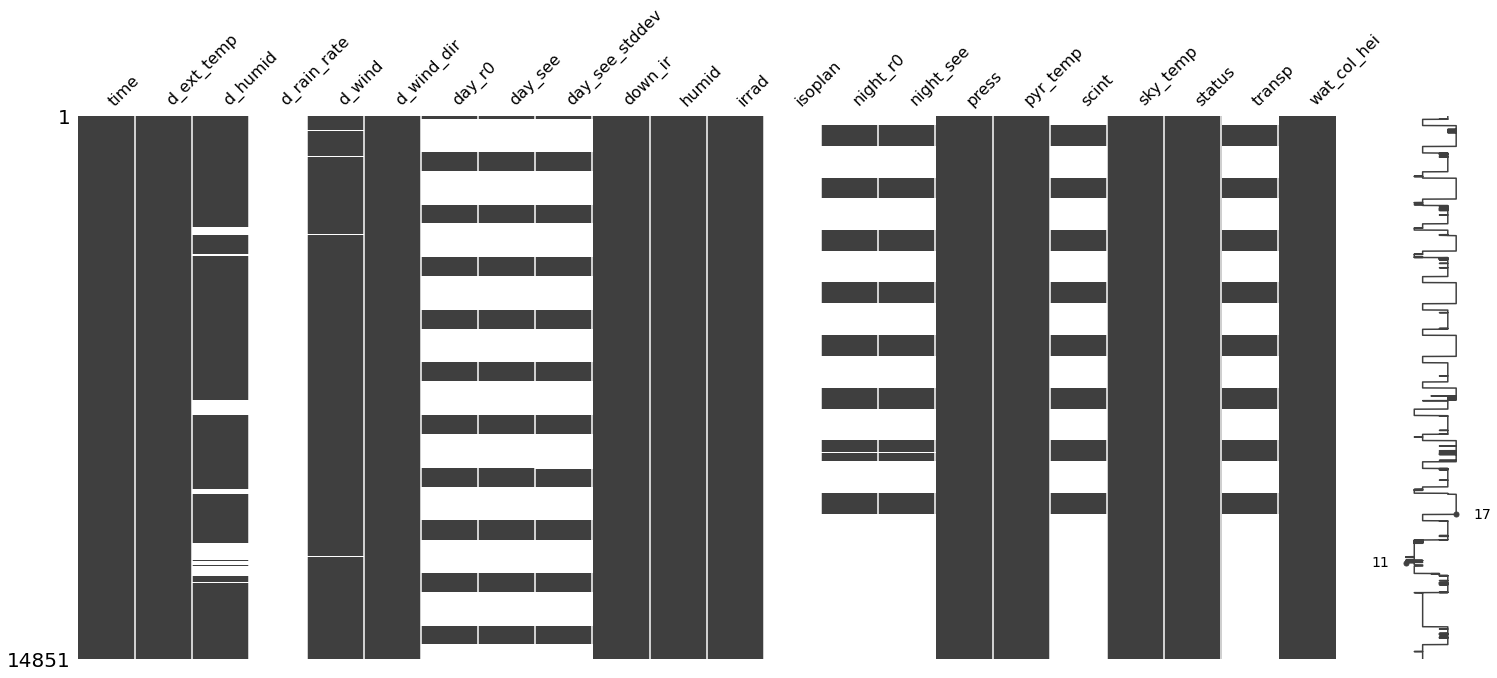

In [2]:
import missingno as msno
missing_df = missingDF(df)
print('Dataframe des variables associées leurs taux de valeurs manquantes')
print(missing_df)
msno.matrix(df[df['time'].dt.month == 7]) # pour juillet


- Les variables continues sans trous (ou presque) sont : __d_ext_temp__ , __d_wind_dir__, __down_ir__, __pyr_temp__, __press__, __sky_temp__, __wat_col_hei__, __humid__, __irrad__

- Le taux de manquants pour les variables à trous qu'on cherche à prédire sont d'env 74%

- Les variables (quasi ou entièrement) vides sont __isoplan__ et __d_rain_rate__

On va supprimer ces deux dernières variables car elles ne nous serviront pas.


In [3]:
df = df.drop(['isoplan','d_rain_rate'],axis=1)

### 2.3 Ajouter les variables supplémentaires

In [ ]:
df = add_features_from_raw_data(df, dic_location['tenerife']) # Ajouter: hour_of_day, month, season, sun_alt
df.to_csv('tenerife2020_extended.csv')
print(df[df['time'].dt.month == 1].info())

### 2.3 On crée des dataframes par catégorie
Cela pourra être utile pour l'observation des données, pour la création de modèle etc.

__Decomposition par saison__

In [9]:
#hiver = pd.concat([df[(df['time'].dt.month >= 12) & (df['time'].dt.day >=1)], df[(df['time'].dt.month <= 2) & (df['time'].dt.day <= 28)]])
#printemps = df[(df['time'].dt.month >= 3) & (df['time'].dt.day >=1) & (df['time'].dt.month <= 5) & (df['time'].dt.day <= 31)]
#ete = df[(df['time'].dt.month >= 6) & (df['time'].dt.day >=1) & (df['time'].dt.month <= 8) & (df['time'].dt.day <= 31)]
#automne = df[(df['time'].dt.month >= 9) & (df['time'].dt.day >=1) & (df['time'].dt.month <= 11) & (df['time'].dt.day <= 31)]
df = pd.read_csv('data/tenerife2020_extended.csv', dtype=dtype)
df.drop(columns=['Unnamed: 0'], inplace=True)
df['time'] = pd.to_datetime(df['time'], unit='ns')
print(df.info())
hiver = df[df['season'] == 1] #12, 1, 2
printemps = df[df['season'] == 2] #3, 4, 5
ete = df[df['season'] == 3] #6, 7, 8
automne = df[df['season'] == 4] #9, 10, 11 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422134 entries, 0 to 422133
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   time            422134 non-null  datetime64[ns]
 1   d_ext_temp      422114 non-null  float32       
 2   d_humid         405752 non-null  float32       
 3   d_wind          367379 non-null  float32       
 4   d_wind_dir      422114 non-null  float32       
 5   day_r0          110080 non-null  float32       
 6   day_see         110080 non-null  float32       
 7   day_see_stddev  108891 non-null  float32       
 8   down_ir         422114 non-null  float32       
 9   humid           422024 non-null  float32       
 10  irrad           422102 non-null  float32       
 11  night_r0        101836 non-null  float32       
 12  night_see       101836 non-null  float32       
 13  press           422114 non-null  float32       
 14  pyr_temp        422114 non-null  flo

<AxesSubplot:>

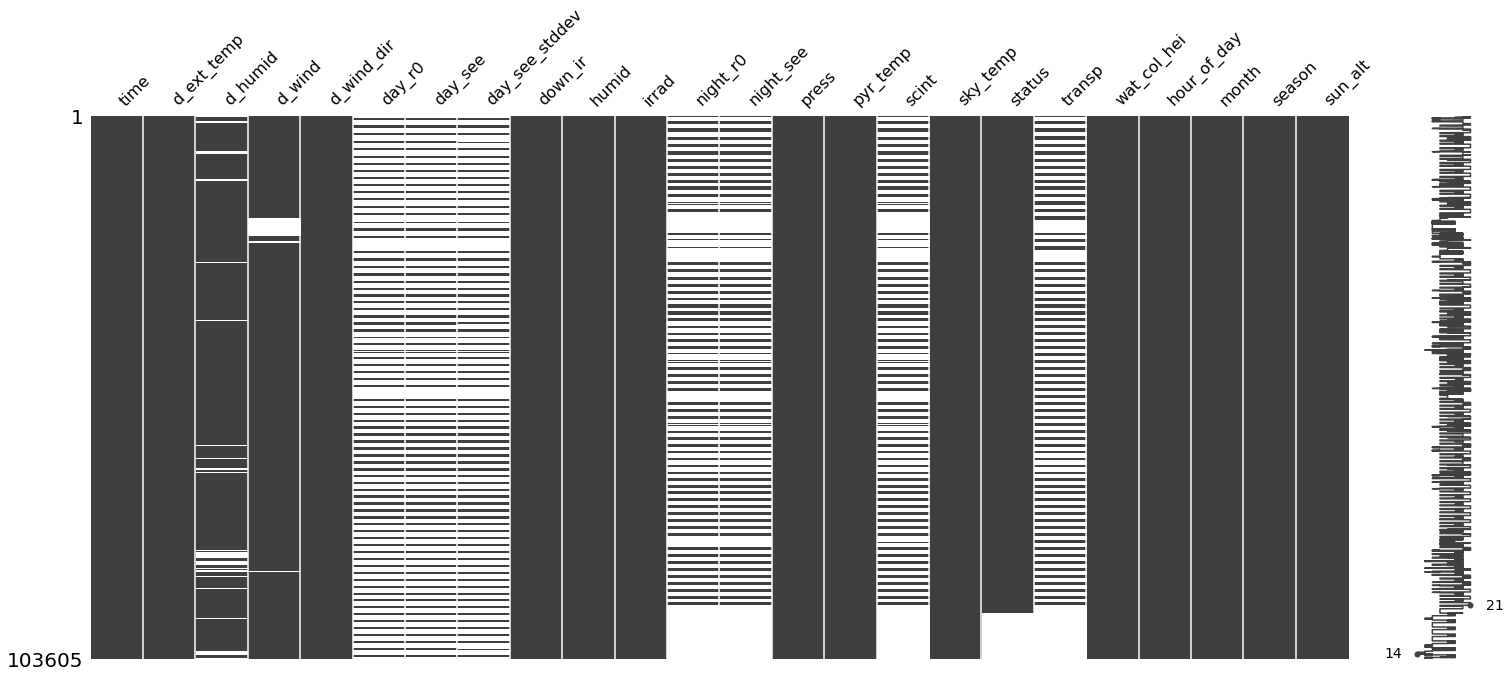

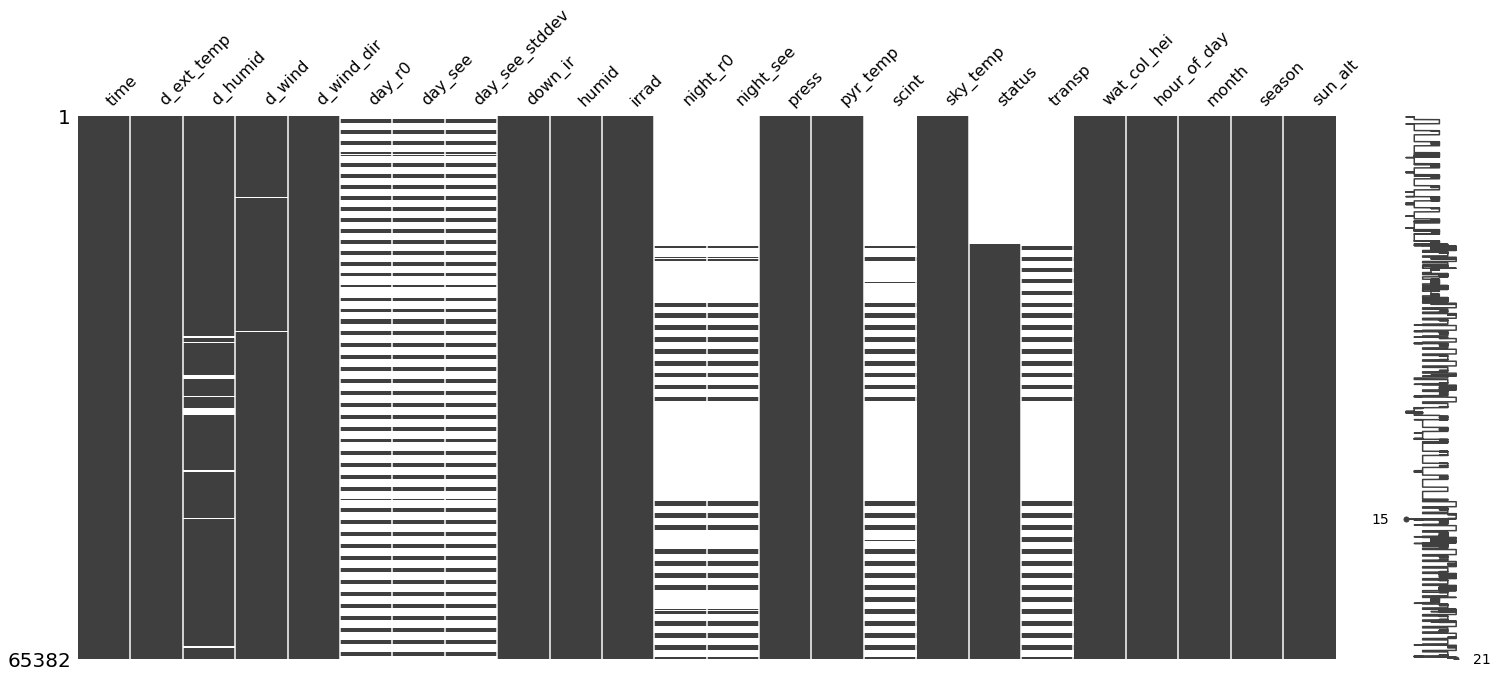

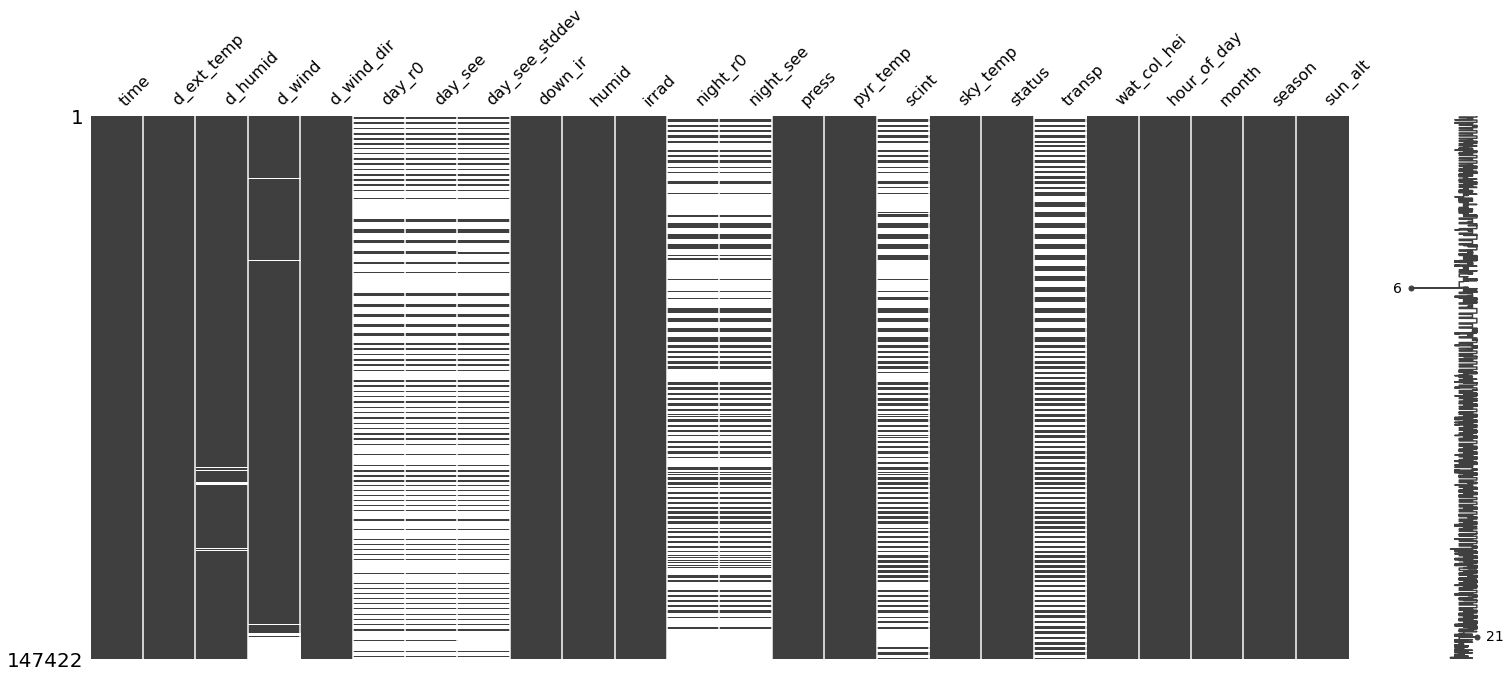

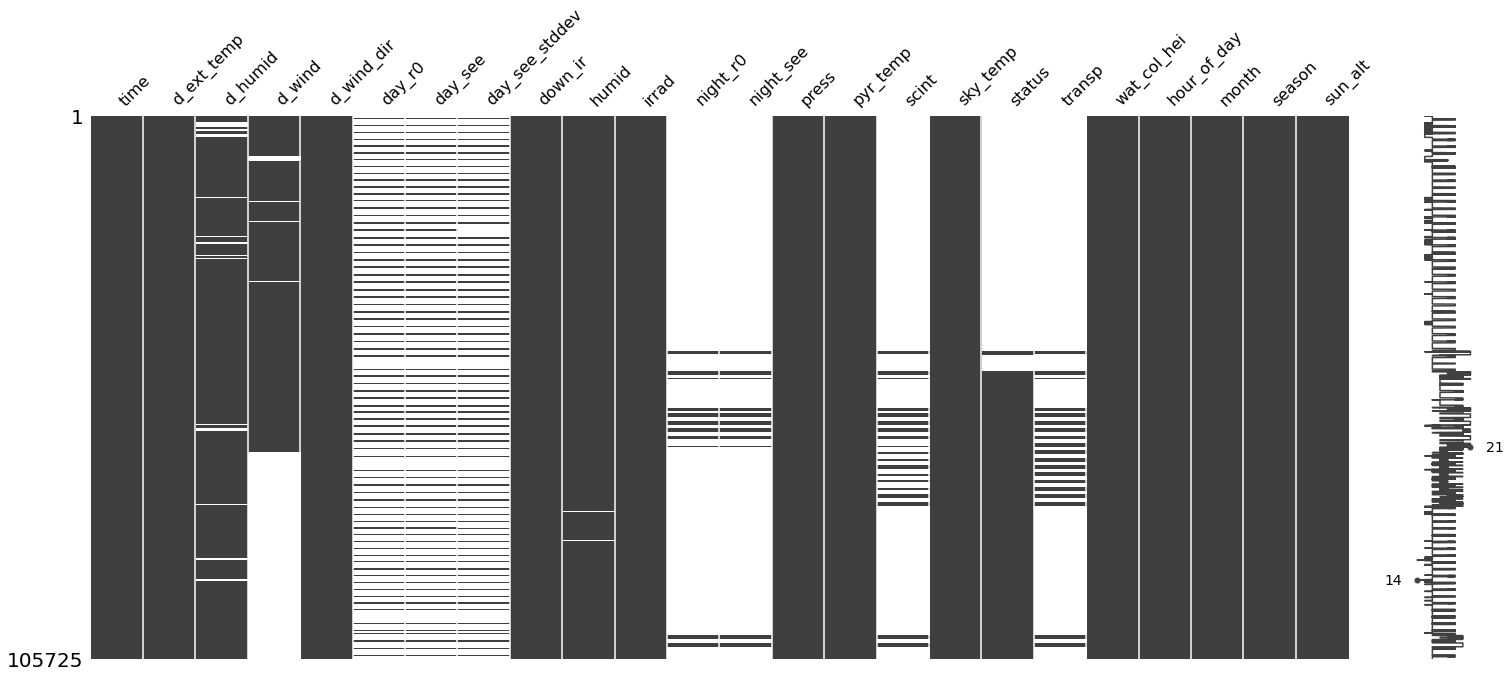

In [10]:
#hiver,automne,printemps,été
#missingDF(printemps)
msno.matrix(printemps)
msno.matrix(ete)
msno.matrix(automne)
msno.matrix(hiver)

__Printemps__ :  peu de valeurs manquantes (__day_r0__, __night_r0__) et peu de val manquantes chez les variables servant à prédire 

__Ete__ : peu de val manquante chez __day_r0__ mais bcp chez __night_r0__ et chez les variables pour prédire

__Automne__ : pas mal de valeurs manquantes (__day_r0__, __night_r0__) mais peu de val manquantes chez les variables servant à prédire

__Hiver__ : bcp de valeurs manquantes autant chez les variables à prédire que chez les variables pouvant servir à prédire (__scint__, __transp__, __d_wind__ etc) = bof

__Decomposition par capteurs__

In [11]:
features_all = ['day_r0', 'day_see', 'day_see_stddev', 'night_r0', 'night_see', 'scint', 'transp', 'd_wind_dir', 'humid', 'd_humid', 'press', 'irrad', 'sky_temp', 'wat_col_hei', 'pyr_temp', 'down_ir']
features_turbulence_day = ['day_r0', 'day_see', 'day_see_stddev']  # Scintillation solar sensor
features_turbulence_night = ['night_r0', 'night_see', 'scint', 'transp'] # DIMM
features_weather = ['d_wind_dir', 'humid', 'd_humid', 'press', 'irrad'] # Weather station
features_thermal = ['sky_temp', 'wat_col_hei', 'pyr_temp', 'down_ir']  # 1,2: zenith sensor, 10°FoV; 3,4: 52° sensor, 40°FoV

In [12]:
corr_table = correlation_table(df, 0.7, features_all)
print_results_table(corr_table, ['Param1', 'Param2', 'Spearman'])

Param1        Param2           Spearman              
pyr_temp      down_ir          1.0                   
sky_temp      wat_col_hei      0.9999999997529158    
day_r0        day_see          -0.9999999917269942   
night_r0      night_see        -0.9956134203811853   
scint         transp           0.8337424391101764    
day_r0        day_see_stddev   -0.830879708663972    
day_see       day_see_stddev   0.8308795177838478    
wat_col_hei   pyr_temp         0.7676775162333511    
wat_col_hei   down_ir          0.7676775162333511    
sky_temp      pyr_temp         0.7676775104377813    
sky_temp      down_ir          0.7676775104377813    


### 2.4 Fonction de plotting

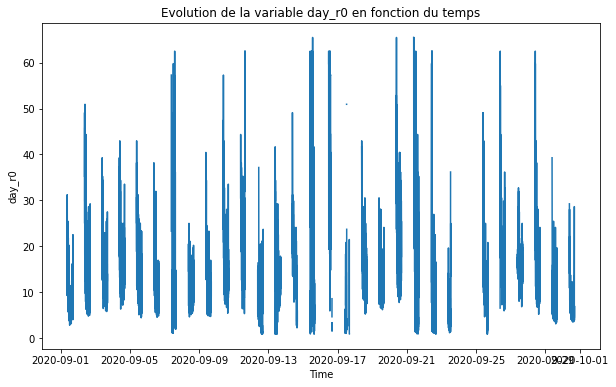

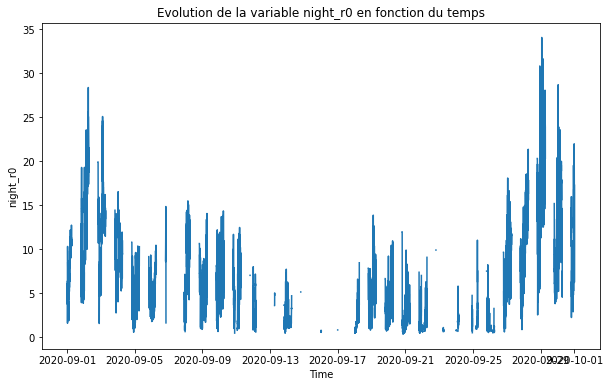

In [13]:
# Dessinez les courbes des variables de juillet.
df_month = df[(df['time'].dt.month == 9)]
plot_one_param(df_month, 'day_r0')
plot_one_param(df_month, 'night_r0')

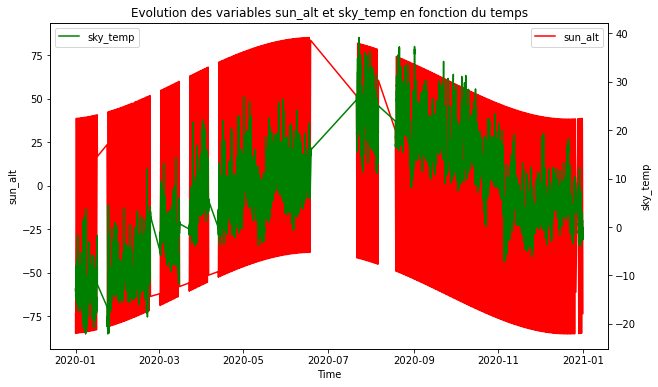

In [14]:
plot_two_params(df, 'sun_alt', 'sky_temp')

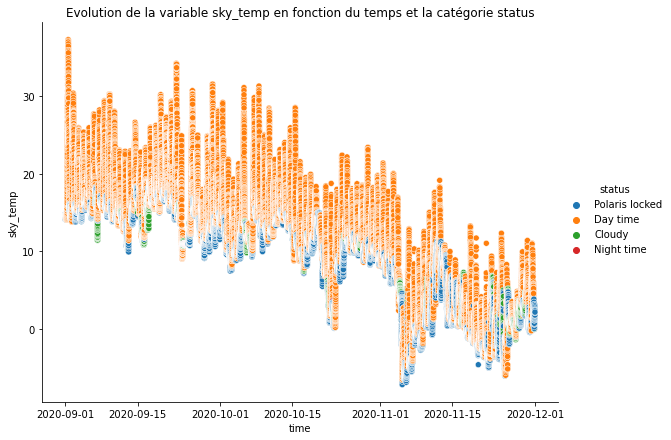

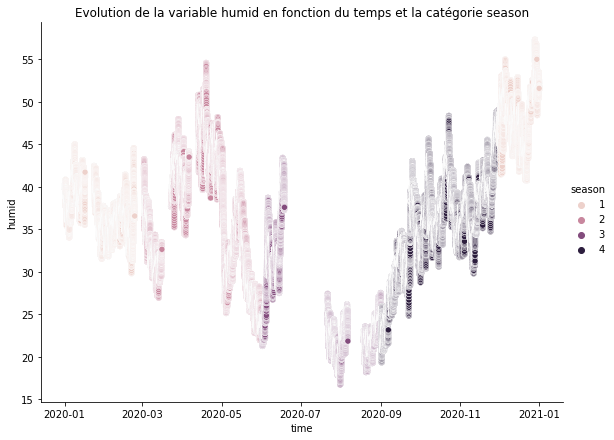

In [15]:
plot_one_params_based_categories(automne, 'sky_temp', 'status')
plot_one_params_based_categories(df, 'humid', 'season')

## 3. Statistiques descriptives

#### Variables quantitatives

In [16]:
df.describe()

,d_ext_temp,d_humid,d_wind,d_wind_dir,day_r0,day_see,day_see_stddev,down_ir,humid,irrad,...,press,pyr_temp,scint,sky_temp,transp,wat_col_hei,hour_of_day,month,season,sun_alt
count,422114.000000,405752.000000,367379.000000,422114.000000,110080.000000,110080.000000,1.088910e+05,422114.000000,422024.000000,422102.000000,...,422114.000000,422114.000000,113377.000000,422114.000000,140213.000000,422114.000000,422134.000000,422134.000000,422134.000000,422134.000000
mean,10.055614,37.644543,26.113029,213.864792,11.975237,2.225297,5.215016e+05,276.391235,35.777855,14.145163,...,768.068359,-9.793648,43.226654,6.589441,82.065773,4.241936,11.504717,6.911073,2.602891,-1.448253
std,5.601721,25.378107,15.294323,112.585999,8.496565,2.758569,3.450371e+07,50.730560,7.685031,5.653921,...,3.896428,12.594412,19.698082,11.028410,56.263191,1.648378,6.930067,3.546752,1.199494,41.547238
min,-3.467000,0.100000,1.609000,9.000000,0.917000,0.210000,1.000000e-02,149.494003,16.750000,7.798090,...,746.979980,-46.549999,0.020000,-22.110001,2.009000,0.876000,0.000000,1.000000,1.000000,-85.135960
25%,5.839000,17.600000,14.484000,133.729996,6.773000,0.910000,3.600000e-01,235.408997,31.299999,8.643990,...,766.380005,-19.309999,28.632999,0.530000,27.167999,3.201000,5.000000,4.000000,1.000000,-36.854418
50%,9.822000,32.500000,24.139999,245.050003,10.338000,1.330000,5.500000e-01,282.415009,36.049999,10.536800,...,769.409973,-7.490000,47.118999,7.230000,82.417999,4.141000,12.000000,8.000000,3.000000,-1.122995
75%,14.350000,51.700001,33.796001,313.450012,15.110000,2.030000,8.300000e-01,316.794006,40.570000,20.573900,...,771.729980,0.250000,58.706001,14.710000,130.330994,5.368000,18.000000,10.000000,4.000000,34.242438
max,27.021999,96.099998,146.449997,351.000000,65.475998,15.000000,4.038450e+09,435.731995,57.330002,20.961201,...,777.359985,22.930000,123.619003,39.169998,251.585007,11.125000,23.000000,12.000000,4.000000,85.096672


__Affichage des box-plot__ : 

<AxesSubplot:>

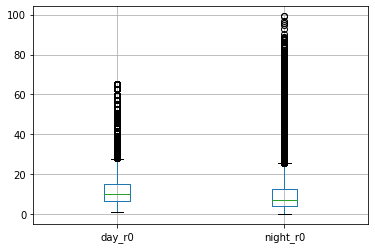

In [17]:
df[['day_r0','night_r0']].boxplot()

__Affichage des histogrammes__ :

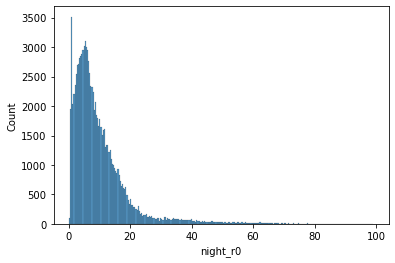

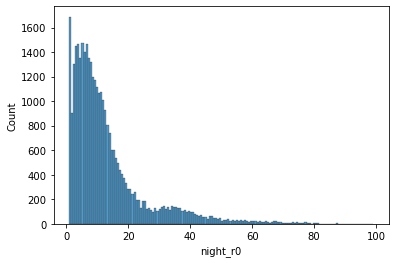

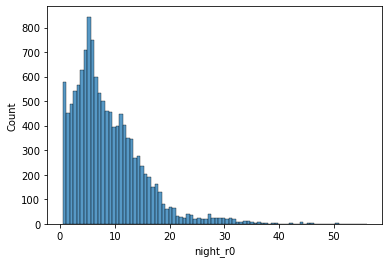

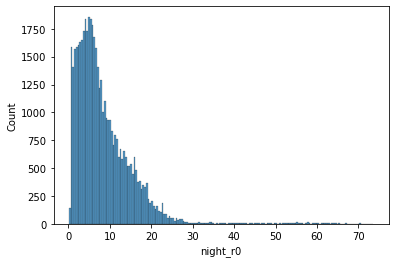

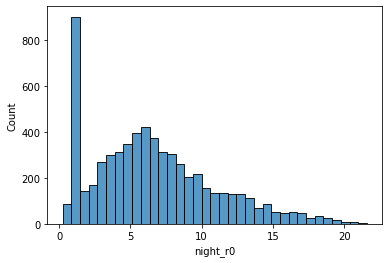

In [18]:
sns.histplot(df.night_r0) #day_r0
plt.show()
sns.histplot(printemps.night_r0) #night_r0
plt.show()
sns.histplot(ete.night_r0) #night_r0
plt.show()
sns.histplot(automne.night_r0) #night_r0
plt.show()
sns.histplot(hiver.night_r0) #night_r0
plt.show()

#### Variables qualitatives

L'hiver


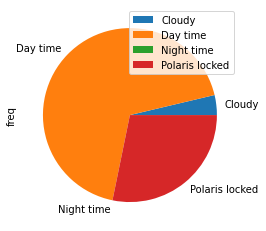

L'automne


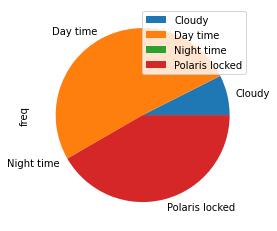

Le printemps


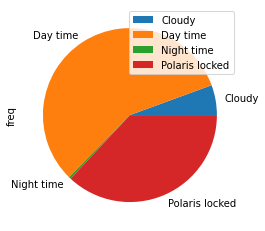

L'été


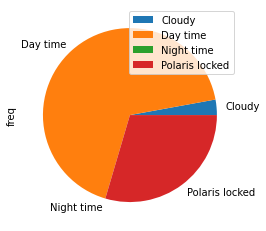

In [19]:
print("L'hiver")
t = pd.crosstab(hiver.status, "freq", normalize = True)
t.plot.pie(subplots=True, figsize = (4, 4))
plt.show()

print("L'automne")
t = pd.crosstab(automne.status, "freq", normalize = True)
t.plot.pie(subplots=True, figsize = (4, 4))
plt.show()

print("Le printemps")
t = pd.crosstab(printemps.status, "freq", normalize = True)
t.plot.pie(subplots=True, figsize = (4, 4))
plt.show()

print("L'été")
t = pd.crosstab(ete.status, "freq", normalize = True)
t.plot.pie(subplots=True, figsize = (4, 4))
plt.show()

In [20]:
#df,hiver,automne,printemps,ete

hiver.status.unique()
print("L'hiver \n", pd.crosstab(hiver.status, "freq"),"\n")

automne.status.unique()
print("L'automne \n", pd.crosstab(automne.status, "freq"),"\n")

printemps.status.unique()
print("Le printemps \n", pd.crosstab(printemps.status, "freq"),"\n")

ete.status.unique()
print("L'été \n", pd.crosstab(ete.status, "freq"))

L'hiver 
 col_0            freq
status               
Cloudy           2100
Day time        38565
Night time          1
Polaris locked  15983 

L'automne 
 col_0            freq
status               
Cloudy          10974
Day time        75027
Night time         12
Polaris locked  61407 

Le printemps 
 col_0            freq
status               
Cloudy           5292
Day time        54113
Night time        381
Polaris locked  35038 

L'été 
 col_0            freq
status               
Cloudy           1431
Day time        33718
Night time          2
Polaris locked  14752


#### Description conjointe de caractères quantitatifs

hiver


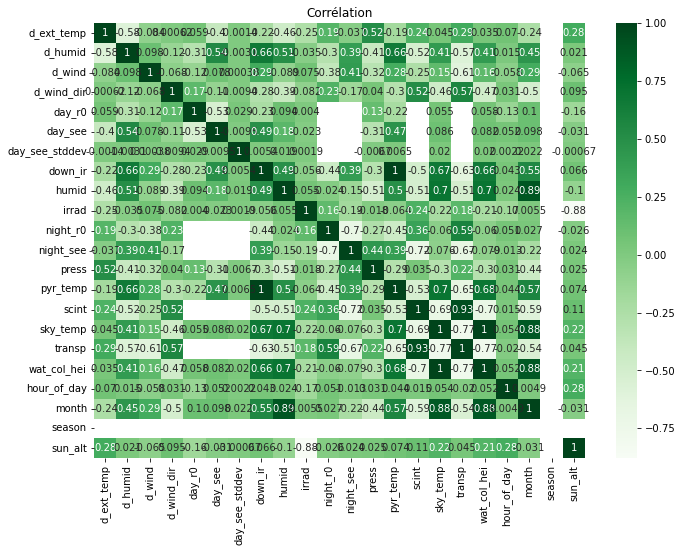

automne


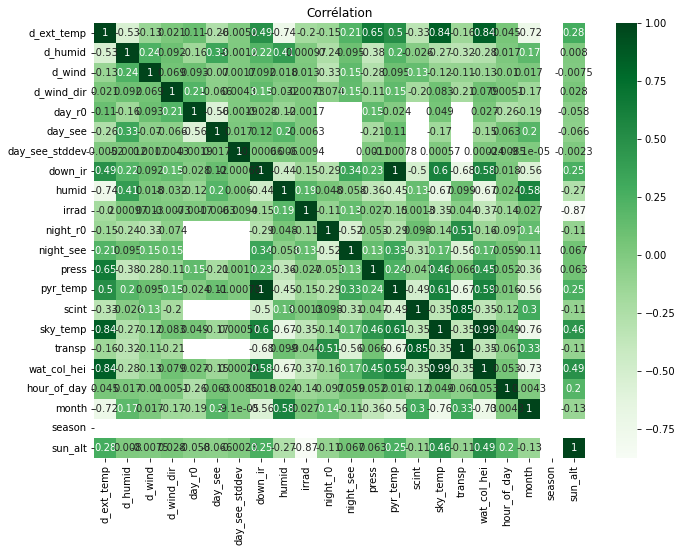

printemps


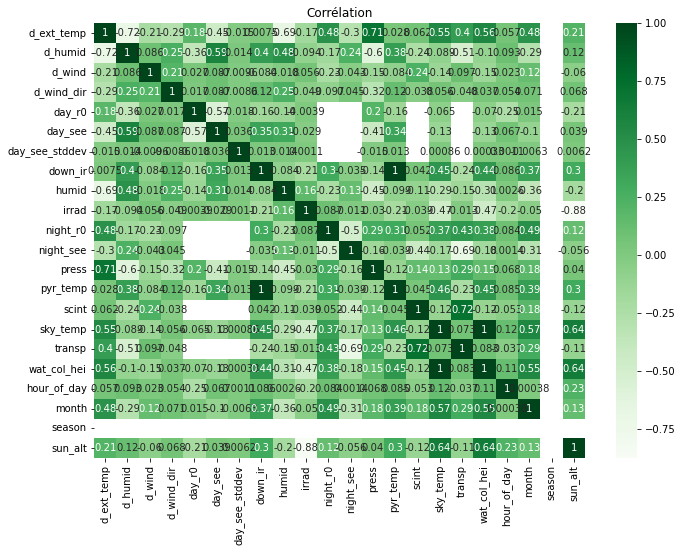

ete


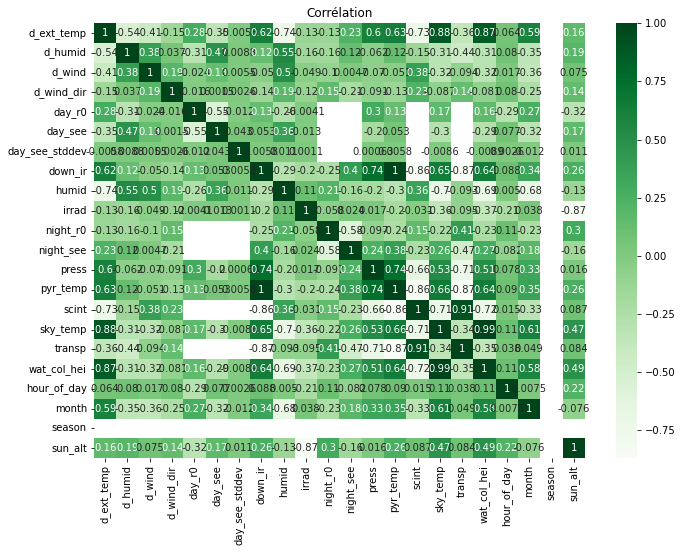

sur l'année


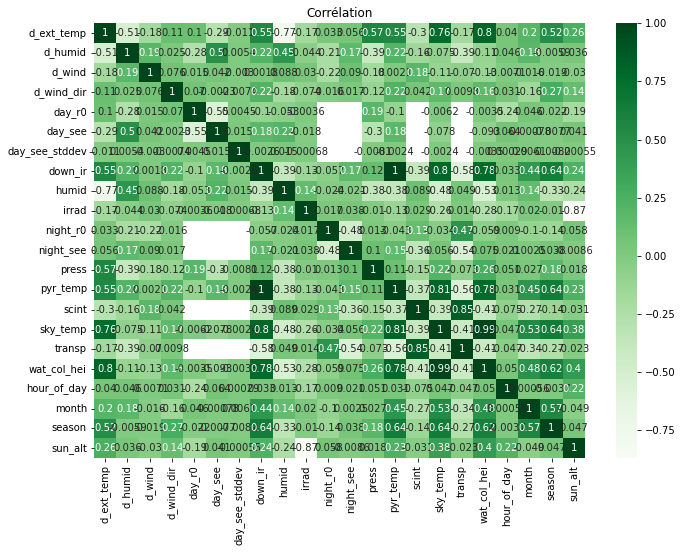

In [21]:
print("hiver")
plot_corr(hiver)
print("automne")
plot_corr(automne)
print("printemps")
plot_corr(printemps)
print("ete")
plot_corr(ete)
print("sur l'année")
plot_corr(df)

## Résumé des corrélations ( $\geq 0.84 \% $ ) : 

Variables corrélées pour toute saison : `sky_temp ~ wat_col_hei` et `pyt_temp ~ down_ir`

### Hiver : 

`transp ~ scint`

### Automne : 

`transp ~ scint`, `d_ext_temp ~ sky_temp`,`d_ext_temp ~ wat_col_hei`

### Printemps : 

### Eté : 

`transp ~ scint`, `d_ext_temp ~ sky_temp`,`d_ext_temp ~ wat_col_hei`, 


Le coefficient de correlation entre wat_col_hei et sky_temp pour la saison printemps est de 99.544 % 



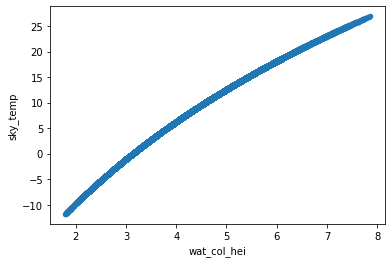

Le coefficient de correlation entre down_ir et pyr_temp pour la saison printemps est de 99.853 % 



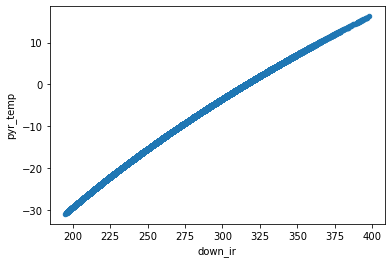

In [22]:
Hiver,Automne,Printemps,Ete = [[hiver,'hiver'],[automne,'automne'],[printemps,'printemps'],[ete,'été']]

plot_corr_saison_variable('wat_col_hei', 'sky_temp', Printemps)
plot_corr_saison_variable('down_ir', 'pyr_temp', Printemps)

### Description conjointe d’un caractère quantitatif et d’un caractère qualitatif

In [23]:
df.groupby("status").mean()

,d_ext_temp,d_humid,d_wind,d_wind_dir,day_r0,day_see,day_see_stddev,down_ir,humid,irrad,...,press,pyr_temp,scint,sky_temp,transp,wat_col_hei,hour_of_day,month,season,sun_alt
status,,,,,,,,,,,,,,,,,,,,,
Cloudy,6.673387,67.894882,33.023590,239.746429,NaN,NaN,NaN,323.125824,39.341152,20.169846,...,766.622131,1.363192,NaN,6.376370,17.282324,4.077362,10.010254,7.641461,3.074860,-38.728414
Day time,10.989617,40.705177,25.582096,210.103104,11.973561,2.259300,588378.68750,290.458496,35.627235,10.001468,...,768.788025,-6.235394,NaN,11.299971,NaN,4.937833,12.370176,7.995581,2.720906,25.661900
Night time,0.498775,93.165909,34.804092,309.969604,NaN,NaN,NaN,316.236694,42.874924,19.921494,...,760.796875,0.080152,25.979769,1.533434,62.580921,3.338593,19.103535,3.305556,2.063131,-28.173277
Polaris locked,10.202215,31.897753,25.649757,219.244537,14.864112,1.870377,413.90921,273.293182,36.356197,19.831404,...,769.130676,-10.265131,43.228428,5.958783,91.853203,4.074132,10.348538,7.489196,2.955992,-37.632262


In [24]:
#ex ou on se concentre sur une variable avec sky_temp

df.groupby("status")["sky_temp"].agg([np.mean, np.std, np.median, np.min, np.max])

,mean,std,median,amin,amax
status,,,,,
Cloudy,6.376370,6.242427,4.13,-13.15,20.190001
Day time,11.299971,9.165211,10.93,-17.73,39.169998
Night time,1.533434,1.904822,1.25,-7.37,20.770000
Polaris locked,5.958783,8.805860,6.45,-18.59,22.450001


<AxesSubplot:xlabel='sky_temp', ylabel='Count'>

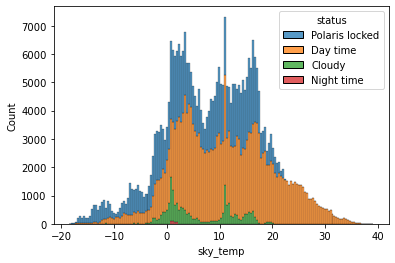

In [25]:
sns.histplot(data = df, x="sky_temp", hue = "status", multiple = "stack")

#### Description conjointe de deux caractères quantitatifs et d’un caractère qualitatif

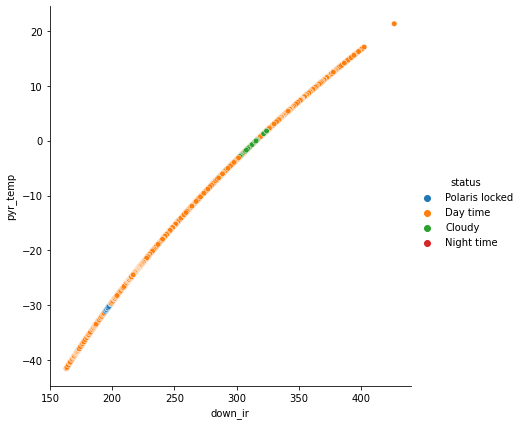

In [26]:
sns.relplot(x = "down_ir", y = "pyr_temp", hue = "status", data = df, height = 6, s = 30)

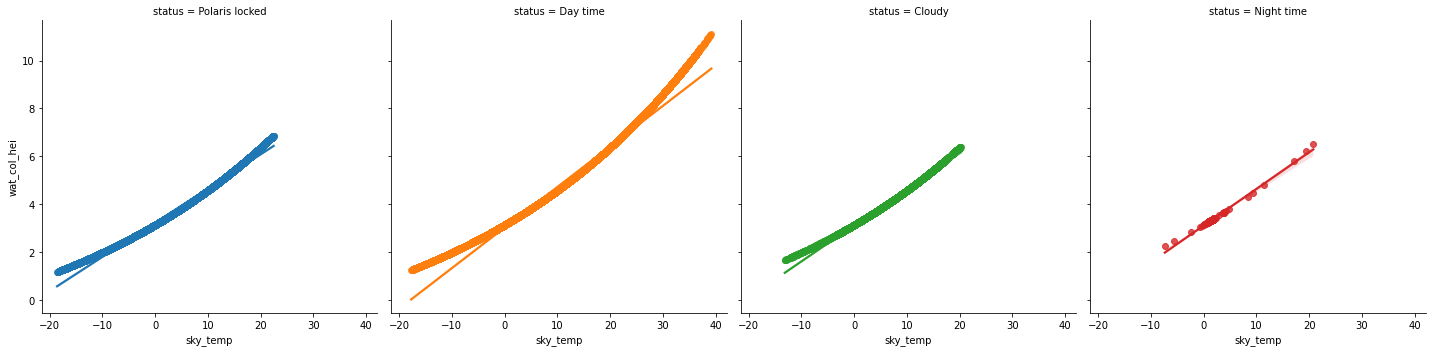

In [27]:
sns.lmplot(data = df, x="sky_temp", y = "wat_col_hei", hue = "status", col = "status")

## 3. Tendance et saisonnalité

### Affichage de la tendance

In [28]:
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
month = df['month'].unique()

plot_df(df, x=df.time, y=df.sky_temp, ylabel = "Sky temperature" ,title='Sky temperature plot',color = 'green')  

plot_df(df, x=df.time, y=df.pyr_temp, ylabel = "Pyr temperature" ,title='Pyr temperature plot', color = 'blue')  

plot_df(df, x=df.time, y=df.day_r0, ylabel = "Day r0" ,title='Day r0 plot', color = 'purple')  

plot_df(df, x=df.time, y=df.night_r0, ylabel = "Night r0" ,title='Night r0 plot')  

plot


NameError: name 'plot_df' is not defined

### Affichage de la saisonnalité (ex : en juillet)

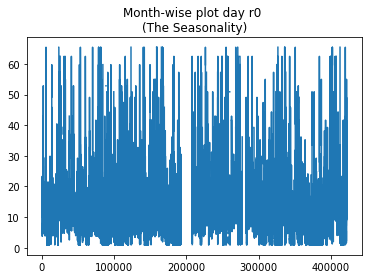

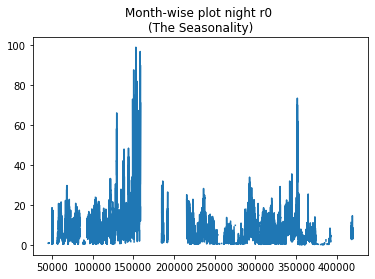

In [29]:
plt.plot('day_r0', data=df.loc[~df.month.isin([7]), :],)
plt.title('Month-wise plot day r0 \n(The Seasonality)', fontsize=12)
plt.show()
plt.plot('night_r0', data=df.loc[~df.month.isin([7]), :],)
plt.title('Month-wise plot night r0 \n(The Seasonality)', fontsize=12)
plt.show()

# Mise en oeuvre algorithme de prédiction des valeurs manquantes

mettre en œuvre des algorithmes de traitement de données pour compléter les valeurs manquantes de la turbulence en utilisant les variables météorologiques, thermiques et supplémentaires. 
Divisez le jeu de données en deux en fonction de la période de la journée (jour et nuit) en utilisant la variable "sun_alt". Les données pour la journée sont "sun_alt > 0°" et celles pour la nuit sont "sun_alt < 0°"

Les variables à compléter: 
- Turbulence de la journée: day_r0 (Quand le soleil est au-dessus de l’horizon -> [sun_alt > 0°])
- Turbulence de la nuit: night_r0 (Quand le soleil est au-dessous de l’horizon -> [sun_alt < 0°])

In [46]:
#Les Entrées du modèle: 
features_weather = ['d_wind_dir', 'humid', 'd_humid', 'press', 'irrad'] 
features_thermal = ['sky_temp', 'wat_col_hei', 'pyr_temp', 'down_ir']
features_extended = ['sun_alt', 'month', 'hour_of_day', 'season']

## Sujet 1: Imputation les données manquantes pour le variable "day_r0"

['day_r0', 'd_wind_dir', 'humid', 'd_humid', 'press', 'irrad', 'sky_temp', 'wat_col_hei', 'pyr_temp', 'down_ir', 'sun_alt', 'month', 'hour_of_day', 'season']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 207924 entries, 444 to 421790
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   day_r0       110080 non-null  float32
 1   d_wind_dir   207924 non-null  float32
 2   humid        207880 non-null  float32
 3   d_humid      203770 non-null  float32
 4   press        207924 non-null  float32
 5   irrad        207923 non-null  float32
 6   sky_temp     207924 non-null  float32
 7   wat_col_hei  207924 non-null  float32
 8   pyr_temp     207924 non-null  float32
 9   down_ir      207924 non-null  float32
 10  sun_alt      207924 non-null  float64
 11  month        207924 non-null  int64  
 12  hour_of_day  207924 non-null  int64  
 13  season       207924 non-null  int64  
dtypes: float32(10), float64(1), int64(3)

<AxesSubplot:>

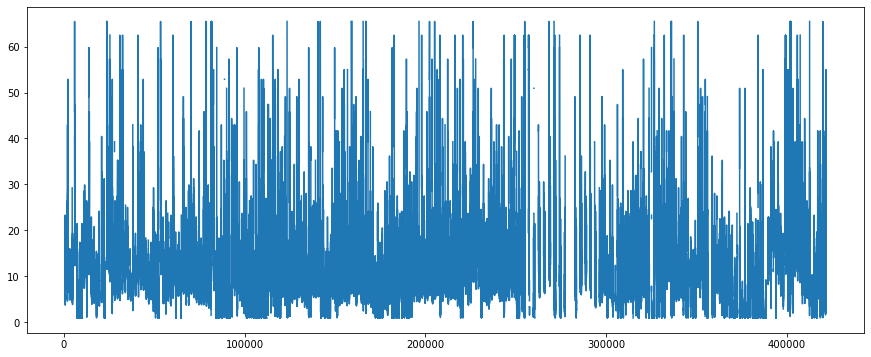

In [50]:
# Selection des données de la journée
vars_day = ['day_r0']
vars_day.extend(features_weather)
vars_day.extend(features_thermal)
vars_day.extend(features_extended)
print(vars_day)
df_jour = df.loc[df['sun_alt'] >= 0, vars_day]
print(df_jour.info())
df_jour['day_r0'].plot(figsize=(15, 6))

## Sujet 2: Imputation les données manquantes pour le variable "night_r0"

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214210 entries, 0 to 422133
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   night_r0     101836 non-null  float32
 1   d_wind_dir   214190 non-null  float32
 2   humid        214144 non-null  float32
 3   d_humid      201982 non-null  float32
 4   press        214190 non-null  float32
 5   irrad        214179 non-null  float32
 6   sky_temp     214190 non-null  float32
 7   wat_col_hei  214190 non-null  float32
 8   pyr_temp     214190 non-null  float32
 9   down_ir      214190 non-null  float32
 10  sun_alt      214210 non-null  float64
 11  month        214210 non-null  int64  
 12  hour_of_day  214210 non-null  int64  
 13  season       214210 non-null  int64  
dtypes: float32(10), float64(1), int64(3)
memory usage: 16.3 MB
None


<AxesSubplot:>

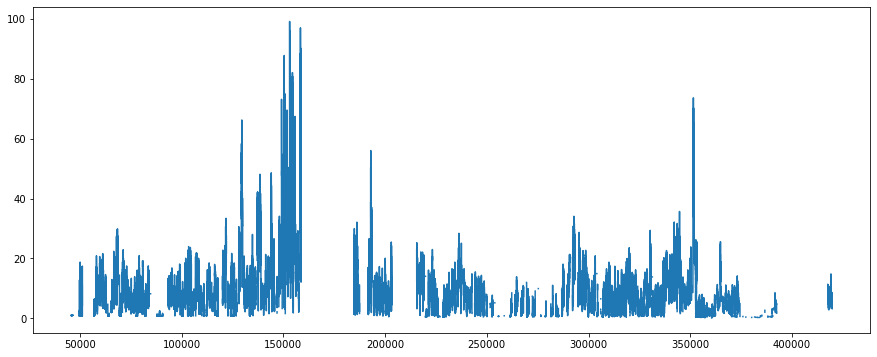

In [51]:
# Selection des données de la nuit
vars_night = ['night_r0']
vars_night.extend(features_weather)
vars_night.extend(features_thermal)
vars_night.extend(features_extended)

df_night = df.loc[df['sun_alt'] < 0, vars_night]
print(df_night.info())
df_night['night_r0'].plot(figsize=(15, 6))

In [ ]:
list_cols = list(df.columns)
list_index = list(df.index)

In [ ]:
dfComplet = complete_dataset(df,5)
dfMissing = missing_dataset(df,5)

In [ ]:
missingDF(dfComplet)

On a un dataset complet qui nous servira pour entrainer notre modèle

In [ ]:
split = int(0.80*len(dfComplet))
split 